In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
xmin = -0.5
xmax = 1
ymin = -0.5
ymax = 1.5
N = 51
N_bc = 80
Re = 100
nu = 1 / Re
lamb = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)

In [3]:
dx = (xmax-xmin)/(N_bc)
dy = (ymax-ymin)/(N_bc)
x_data = np.arange(xmin+dx, xmax, dx)
y_data = np.arange(ymin+dy, ymax, dy)
#print(dx)
#print(dy)
#print("X_data: ", x_data)
#print("Y_data: ", y_data)

x = []
y = []
x.append(xmin)
y.append(ymin)
x.append(xmin)
y.append(ymax)
x.append(xmax)
y.append(ymin)
x.append(xmax)
y.append(ymax)
for i in range(N_bc-1):
    x.append(xmin)
    y.append(y_data[i])
    x.append(xmax)
    y.append(y_data[i])
    x.append(x_data[i])
    y.append(ymin)
    x.append(x_data[i])
    y.append(ymax)

x = np.array(x, dtype=float)
y = np.array(y, dtype=float)
X_bc = np.ndarray.reshape(x, (x.shape[0],1))
Y_bc = np.ndarray.reshape(y, (y.shape[0],1))

S_bc = np.zeros((4*N_bc, 3))
U_bc = 1-(np.exp(lamb*X_bc))*(np.cos(2*math.pi*Y_bc))
V_bc = (lamb/(2*math.pi))*(np.exp(lamb*X_bc))*(np.sin(2*math.pi*Y_bc))
P_bc = (1/2)*(1-(np.exp(2*lamb*X_bc)))
S_bc[:,0:1] = np.ndarray.reshape(U_bc, (U_bc.shape[0],1))
S_bc[:,1:2] = np.ndarray.reshape(V_bc, (V_bc.shape[0],1))
S_bc[:,2:] = np.ndarray.reshape(P_bc, (P_bc.shape[0],1))

#print("X_bc: ", X_bc.shape)
#print("Y_bc: ", Y_bc.shape)

# print("X_bc: ", x_bc)
# print("Y_bc: ", y_bc)

# for i in range(4*N):
#     print(x_bc[i], " ", y_bc[i])

In [4]:
X_bc = Variable(torch.from_numpy(X_bc).float(), requires_grad=False).to(device)
Y_bc = Variable(torch.from_numpy(Y_bc).float(), requires_grad=False).to(device)
S_bc = Variable(torch.from_numpy(S_bc).float(), requires_grad=False).to(device)

x = np.arange(xmin, xmax, (xmax-xmin)/N)
y = np.arange(ymin, ymax, (ymax-ymin)/N)
X, Y = np.meshgrid(x,y)
X = X.flatten()[:,None]
Y = Y.flatten()[:,None]
F = np.zeros_like(X)

X = Variable(torch.from_numpy(X).float(), requires_grad=True).to(device)
Y = Variable(torch.from_numpy(Y).float(), requires_grad=True).to(device)
F = Variable(torch.from_numpy(F).float(), requires_grad=True).to(device)

In [5]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layer1 = nn.Linear(2,20)
        self.layer2 = nn.Linear(20,20)
        self.layer3 = nn.Linear(20,20)
        self.layer4 = nn.Linear(20,20)
        self.layer5 = nn.Linear(20,20)
        self.layer6 = nn.Linear(20,20)
        self.output_layer = nn.Linear(20,3)

    def forward(self, x, y): 
        inputs = torch.cat([x, y], axis=1)
        layer1_out = torch.tanh(self.layer1(inputs))
        layer2_out = torch.tanh(self.layer2(layer1_out))
        layer3_out = torch.tanh(self.layer3(layer2_out))
        layer4_out = torch.tanh(self.layer4(layer3_out))
        layer5_out = torch.tanh(self.layer5(layer4_out))
        layer6_out = torch.tanh(self.layer5(layer5_out))
        output = self.output_layer(layer6_out) 
        return output

In [6]:
pinn = PINN()
pinn = pinn.to(device)
mse_cost_function = nn.MSELoss() 
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=40000, gamma=0.1, last_epoch=-1, verbose=False)

In [7]:
def residual(x, y, pinn):
    s = pinn.forward(x, y)
    u = s[:,0:1]
    v = s[:,1:2]
    p = s[:,2:]

    du_dx = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    dv_dx = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    dp_dx = torch.autograd.grad(p.sum(), x, create_graph=True)[0]

    du_dy = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    dv_dy = torch.autograd.grad(v.sum(), y, create_graph=True)[0]
    dp_dy = torch.autograd.grad(p.sum(), y, create_graph=True)[0]

    du_dxx = torch.autograd.grad(du_dx.sum(), x, create_graph=True)[0]
    dv_dxx = torch.autograd.grad(dv_dx.sum(), x, create_graph=True)[0]
    du_dyy = torch.autograd.grad(du_dy.sum(), y, create_graph=True)[0]
    dv_dyy = torch.autograd.grad(dv_dy.sum(), y, create_graph=True)[0]

    f1 = u*du_dx + v*du_dy + dp_dx - nu*(du_dxx + du_dyy)
    f2 = u*dv_dx + v*dv_dy + dp_dy - nu*(dv_dxx + dv_dyy)
    f3 = du_dx + dv_dy
    f = f1 + f2 + f3
    return f

In [8]:
iterations = 125000
for epoch in range(iterations):
    optimizer.zero_grad()
    
    PINN_S_bc = pinn.forward(X_bc, Y_bc)
    MSE_U = mse_cost_function(PINN_S_bc, S_bc)

    PINN_Residual = residual(X, Y, pinn)
    MSE_F = mse_cost_function(PINN_Residual, F)

    Loss = MSE_U + MSE_F

    Loss.backward()
    optimizer.step()
    scheduler.step()

    with torch.autograd.no_grad():
        if epoch%500 == 0:
            print('Epoch %d, Loss: %.4e, Loss_u: %.4e, Loss_f: %.4e' % (epoch, Loss, MSE_U, MSE_F))
            current_lr = optimizer.param_groups[0]['lr']

Epoch 0, Loss: 1.3376e+00, Loss_u: 1.3375e+00, Loss_f: 1.5171e-04


C:\Users\ameyv\anaconda3\envs\amey-pinn\lib\site-packages\torch\autograd\__init__.py:197: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [2601, 1], strides() = [1, 0]
param.sizes() = [2601, 1], strides() = [1, 0] (Triggered internally at C:\cb\pytorch_1000000000000\work\torch/csrc/autograd/functions/accumulate_grad.h:202.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 500, Loss: 1.9450e-01, Loss_u: 1.9383e-01, Loss_f: 6.7431e-04
Epoch 1000, Loss: 1.7054e-01, Loss_u: 1.7010e-01, Loss_f: 4.3573e-04
Epoch 1500, Loss: 1.6987e-01, Loss_u: 1.6946e-01, Loss_f: 4.1042e-04
Epoch 2000, Loss: 1.6753e-01, Loss_u: 1.6697e-01, Loss_f: 5.5698e-04
Epoch 2500, Loss: 1.5447e-01, Loss_u: 1.5278e-01, Loss_f: 1.6908e-03
Epoch 3000, Loss: 1.5083e-01, Loss_u: 1.5050e-01, Loss_f: 3.2705e-04
Epoch 3500, Loss: 1.4963e-01, Loss_u: 1.4936e-01, Loss_f: 2.7405e-04
Epoch 4000, Loss: 1.4840e-01, Loss_u: 1.4795e-01, Loss_f: 4.5632e-04
Epoch 4500, Loss: 1.4578e-01, Loss_u: 1.4505e-01, Loss_f: 7.3330e-04
Epoch 5000, Loss: 1.0833e-01, Loss_u: 1.0612e-01, Loss_f: 2.2089e-03
Epoch 5500, Loss: 9.0991e-02, Loss_u: 9.0669e-02, Loss_f: 3.2185e-04
Epoch 6000, Loss: 8.0072e-02, Loss_u: 7.9688e-02, Loss_f: 3.8378e-04
Epoch 6500, Loss: 6.3561e-02, Loss_u: 6.2299e-02, Loss_f: 1.2623e-03
Epoch 7000, Loss: 1.1072e-02, Loss_u: 9.3005e-03, Loss_f: 1.7712e-03
Epoch 7500, Loss: 3.0633e-03, Loss_

Epoch 59500, Loss: 1.0793e-05, Loss_u: 7.0182e-06, Loss_f: 3.7746e-06
Epoch 60000, Loss: 1.0666e-05, Loss_u: 6.9251e-06, Loss_f: 3.7413e-06
Epoch 60500, Loss: 1.0865e-05, Loss_u: 6.8151e-06, Loss_f: 4.0499e-06
Epoch 61000, Loss: 1.0412e-05, Loss_u: 6.7359e-06, Loss_f: 3.6765e-06
Epoch 61500, Loss: 1.0291e-05, Loss_u: 6.6441e-06, Loss_f: 3.6468e-06
Epoch 62000, Loss: 1.0170e-05, Loss_u: 6.5560e-06, Loss_f: 3.6139e-06
Epoch 62500, Loss: 1.0066e-05, Loss_u: 6.4771e-06, Loss_f: 3.5892e-06
Epoch 63000, Loss: 9.9492e-06, Loss_u: 6.3909e-06, Loss_f: 3.5582e-06
Epoch 63500, Loss: 1.0126e-05, Loss_u: 6.3397e-06, Loss_f: 3.7858e-06
Epoch 64000, Loss: 9.7085e-06, Loss_u: 6.2162e-06, Loss_f: 3.4923e-06
Epoch 64500, Loss: 9.7101e-06, Loss_u: 6.1591e-06, Loss_f: 3.5510e-06
Epoch 65000, Loss: 9.4947e-06, Loss_u: 6.0584e-06, Loss_f: 3.4363e-06
Epoch 65500, Loss: 9.4127e-06, Loss_u: 5.9921e-06, Loss_f: 3.4205e-06
Epoch 66000, Loss: 9.3138e-06, Loss_u: 5.9183e-06, Loss_f: 3.3955e-06
Epoch 66500, Loss: 9

Epoch 118000, Loss: 4.5351e-06, Loss_u: 2.6501e-06, Loss_f: 1.8850e-06
Epoch 118500, Loss: 4.5115e-06, Loss_u: 2.6344e-06, Loss_f: 1.8771e-06
Epoch 119000, Loss: 4.4889e-06, Loss_u: 2.6205e-06, Loss_f: 1.8684e-06
Epoch 119500, Loss: 4.4662e-06, Loss_u: 2.6060e-06, Loss_f: 1.8602e-06
Epoch 120000, Loss: 4.4435e-06, Loss_u: 2.5915e-06, Loss_f: 1.8520e-06
Epoch 120500, Loss: 4.4420e-06, Loss_u: 2.5905e-06, Loss_f: 1.8515e-06
Epoch 121000, Loss: 4.4399e-06, Loss_u: 2.5891e-06, Loss_f: 1.8509e-06
Epoch 121500, Loss: 4.4373e-06, Loss_u: 2.5873e-06, Loss_f: 1.8499e-06
Epoch 122000, Loss: 4.4338e-06, Loss_u: 2.5849e-06, Loss_f: 1.8489e-06
Epoch 122500, Loss: 4.4291e-06, Loss_u: 2.5818e-06, Loss_f: 1.8472e-06
Epoch 123000, Loss: 4.4229e-06, Loss_u: 2.5778e-06, Loss_f: 1.8451e-06
Epoch 123500, Loss: 4.4155e-06, Loss_u: 2.5732e-06, Loss_f: 1.8424e-06
Epoch 124000, Loss: 4.4068e-06, Loss_u: 2.5676e-06, Loss_f: 1.8392e-06
Epoch 124500, Loss: 4.3965e-06, Loss_u: 2.5610e-06, Loss_f: 1.8355e-06


In [9]:
S = torch.zeros((N*N, 3))
U = 1-(torch.exp(lamb*X))*(torch.cos(2*math.pi*Y))
V = (lamb/(2*math.pi))*(torch.exp(lamb*X))*(torch.sin(2*math.pi*Y))
P = (1/2)*(1-(torch.exp(2*lamb*X)))
S[:,0:1] = torch.reshape(U, (U.shape[0],1))
S[:,1:2] = torch.reshape(V, (V.shape[0],1))
S[:,2:] = torch.reshape(P, (P.shape[0],1))

In [10]:
s_pred = pinn(X, Y)

# Relative L2 Error
error_s = torch.linalg.norm(S-s_pred,2)/torch.linalg.norm(S,2)
print('Relative L2 Error: %e' % (error_s))

Relative L2 Error: 5.038475e-03


In [11]:
u_test = torch.reshape(U, (N,N)).detach().numpy()
v_test = torch.reshape(V, (N,N)).detach().numpy()
p_test = torch.reshape(P, (N,N)).detach().numpy()
u_pred = torch.reshape(s_pred[:,0], (N,N)).detach().numpy()
v_pred = torch.reshape(s_pred[:,1], (N,N)).detach().numpy()
p_pred = torch.reshape(s_pred[:,2], (N,N)).detach().numpy()

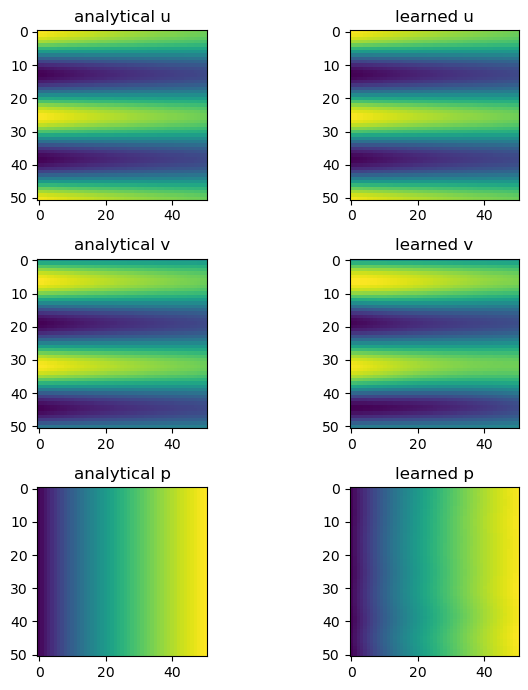

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(7, 7))
axs[0, 0].imshow(u_test)
axs[0, 0].set_title('analytical u')
axs[1, 0].imshow(v_test)
axs[1, 0].set_title('analytical v')
axs[2, 0].imshow(p_test)
axs[2, 0].set_title('analytical p')
axs[0, 1].imshow(u_pred)
axs[0, 1].set_title('learned u')
axs[1, 1].imshow(v_pred)
axs[1, 1].set_title('learned v')
axs[2, 1].imshow(p_pred)
axs[2, 1].set_title('learned p')
fig.tight_layout()

In [13]:
params = pinn.state_dict()
print(params.keys())

odict_keys(['layer1.weight', 'layer1.bias', 'layer2.weight', 'layer2.bias', 'layer3.weight', 'layer3.bias', 'layer4.weight', 'layer4.bias', 'layer5.weight', 'layer5.bias', 'layer6.weight', 'layer6.bias', 'output_layer.weight', 'output_layer.bias'])


In [14]:
flattened_weights = []
for key in params.keys():
    flattened_tensor = torch.reshape(params[key], (-1,)).tolist()
    for val in flattened_tensor:
        flattened_weights.append(val)
weights_array = np.array(flattened_weights)
np.savetxt('data/weights/weights_'+str(Re)+'.txt', weights_array)